In [2]:
%matplotlib inline

# Target mass sensitivity calculation

In [3]:
%run sensitivity_time_functions.py

In [4]:
dist_m81 = 3.6 * u.Mpc

In [5]:
# mass_target = 4e4 * u.solMass # 
# mass_target = 1.e5 * u.solMass # 
mass_target = 2e5 * u.solMass #
# mass_target = 2.5e5 * u.solMass #

sigma_mass = mass_target / 5.

In [6]:
co_intint = h2mass_to_co_brightness(sigma_mass,
                            alpha_CO=4.35*(u.solMass / u.pc**2) / (u.K * u.km / u.s),
                            R21=R21_l22,
                            R32=R32_l22,
                            distance=dist_m81,
                            # beam_size=3.5*u.arcsec,
                            beam_size=4*u.arcsec,
                            to_jy=True,
                            )

co_intint

{'CO10': <Quantity 0.29225581 Jy km / s>,
 'CO21': <Quantity 0.75983875 Jy km / s>,
 'CO32': <Quantity 0.85476421 Jy km / s>}

In [7]:
co_intint_K = h2mass_to_co_brightness(sigma_mass,
                            alpha_CO=4.35*(u.solMass / u.pc**2) / (u.K * u.km / u.s),
                            R21=R21_l22,
                            R32=R32_l22,
                            distance=dist_m81,
                            # beam_size=3.5*u.arcsec,
                            beam_size=4*u.arcsec,
                            to_jy=False,
                            )

co_intint_K

{'CO10': <Quantity 1.68002997 K km / s>,
 'CO21': <Quantity 1.09201948 K km / s>,
 'CO32': <Quantity 0.54600974 K km / s>}

In [8]:
target_rms_intint = co_intint['CO21']

target_rms_intint

<Quantity 0.75983875 Jy km / s>

In [9]:
5 * target_rms_intint

<Quantity 3.79919374 Jy km / s>

In [10]:
target_rms_intint_K = co_intint_K['CO21']

target_rms_intint_K

<Quantity 1.09201948 K km / s>

In [11]:
linewidth = 5 * u.km / u.s

In [12]:
target_rms_peak = target_rms_intint / linewidth

target_rms_peak

<Quantity 0.15196775 Jy>

In [13]:
target_rms_peak.to(u.mJy)

<Quantity 151.9677494 mJy>

In [14]:
target_rms_peak_K = target_rms_intint_K / linewidth

target_rms_peak_K

<Quantity 0.2184039 K>

# SMA time estimates



## COM with 8 antennas

Scale from the whole track to account for opacity variations with elevation:


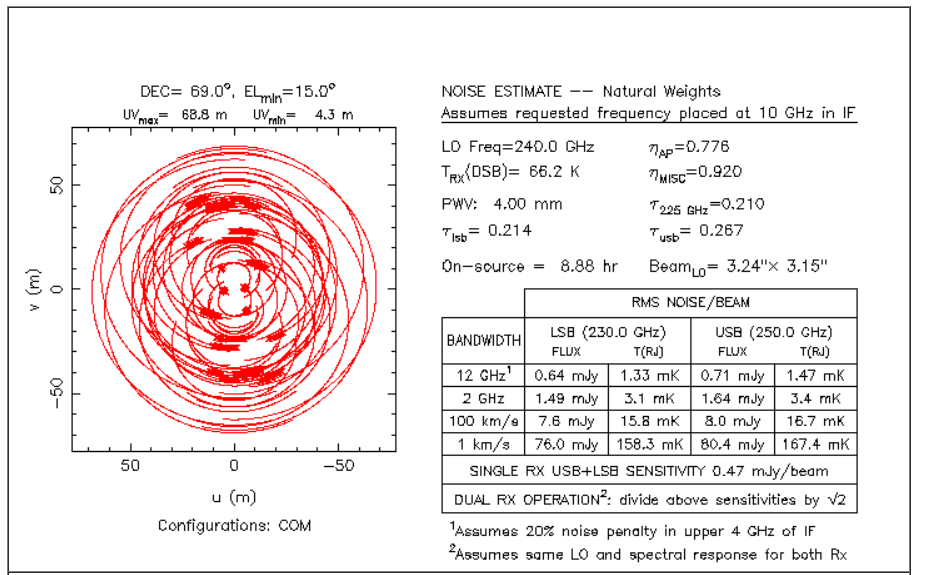


In [15]:
time_onsource_calc = 8.88 * u.h

rms_calc = 80 * u.mJy / np.sqrt(2) / np.sqrt(linewidth.value)

In [16]:
time_on_source_needed = time_onsource_calc.to(u.min) * (rms_calc / target_rms_peak.to(u.mJy))**2

time_on_source_needed

<Quantity 14.76526775 min>

##  SUB with 7 antennas

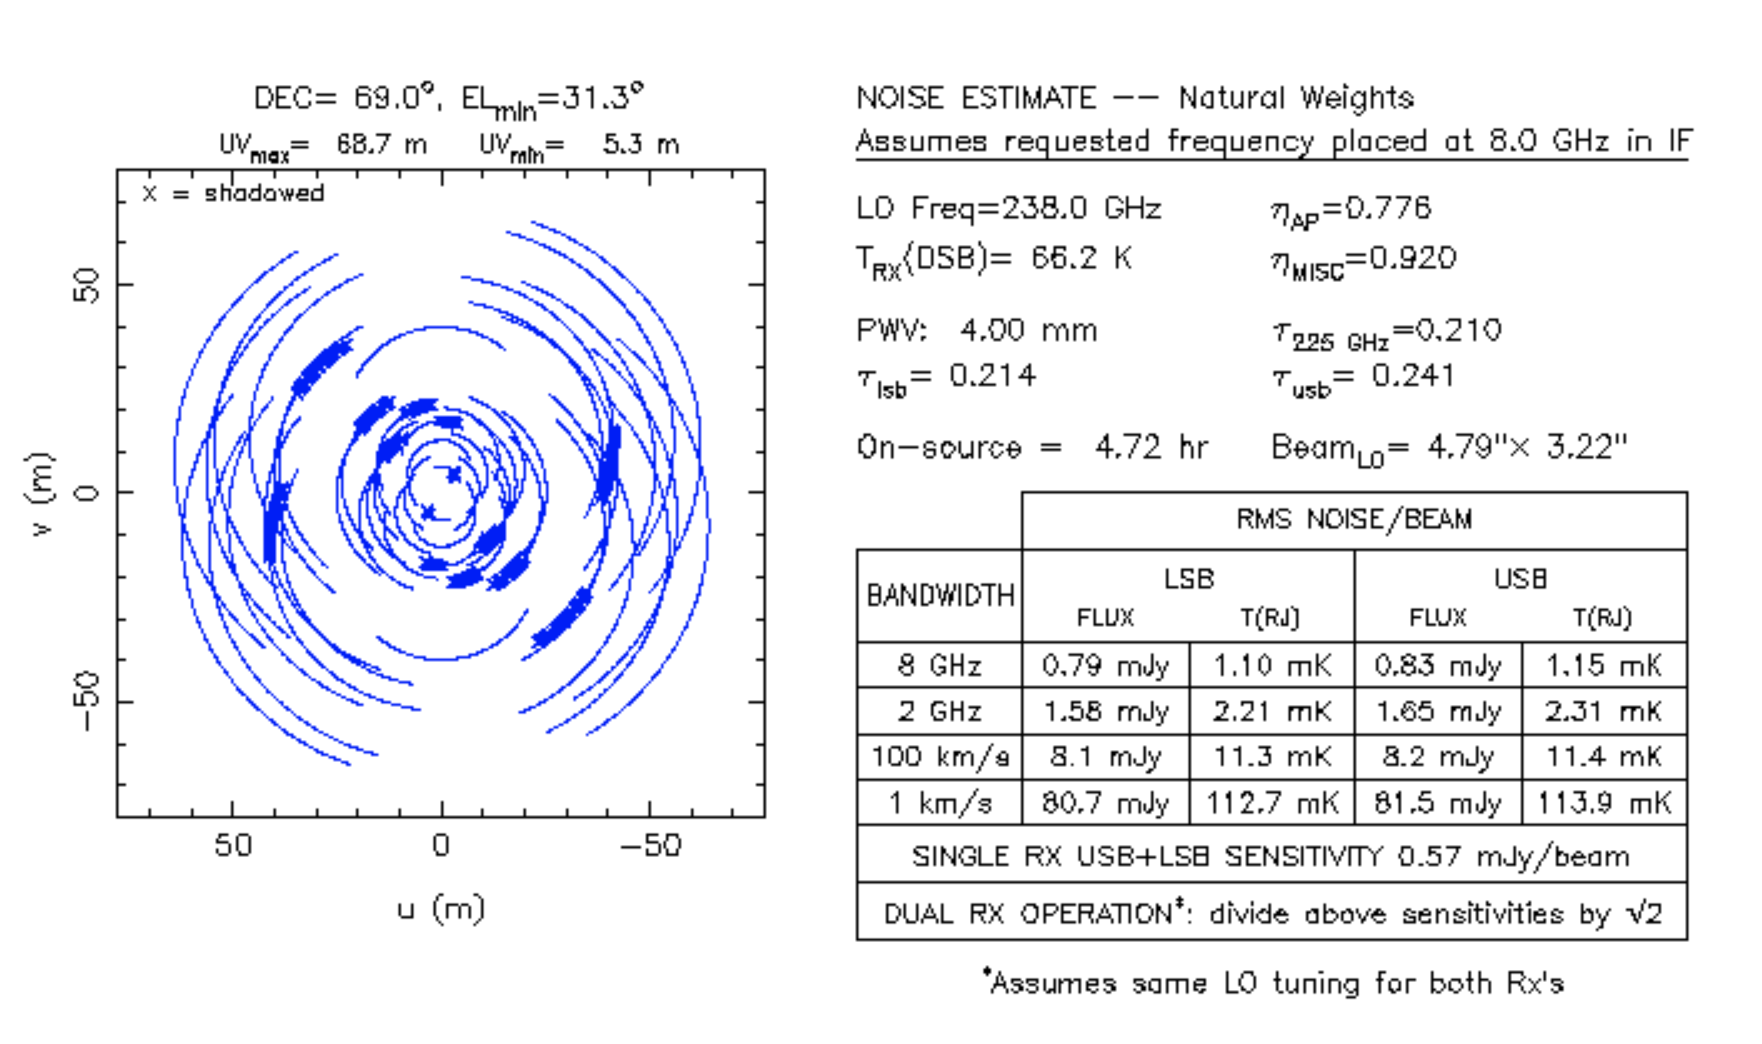

In [17]:
time_onsource_calc = 4.7 * u.h

rms_calc = 80 * u.mJy / np.sqrt(2) / np.sqrt(linewidth.value)

time_on_source_needed = time_onsource_calc.to(u.min) * (rms_calc / target_rms_peak.to(u.mJy))**2

time_on_source_needed


<Quantity 7.81495027 min>

That scaling increases the time by ~2x. We should use this as the benchmark, then.

## 6 antennas in COM-North

**This is our current target!**

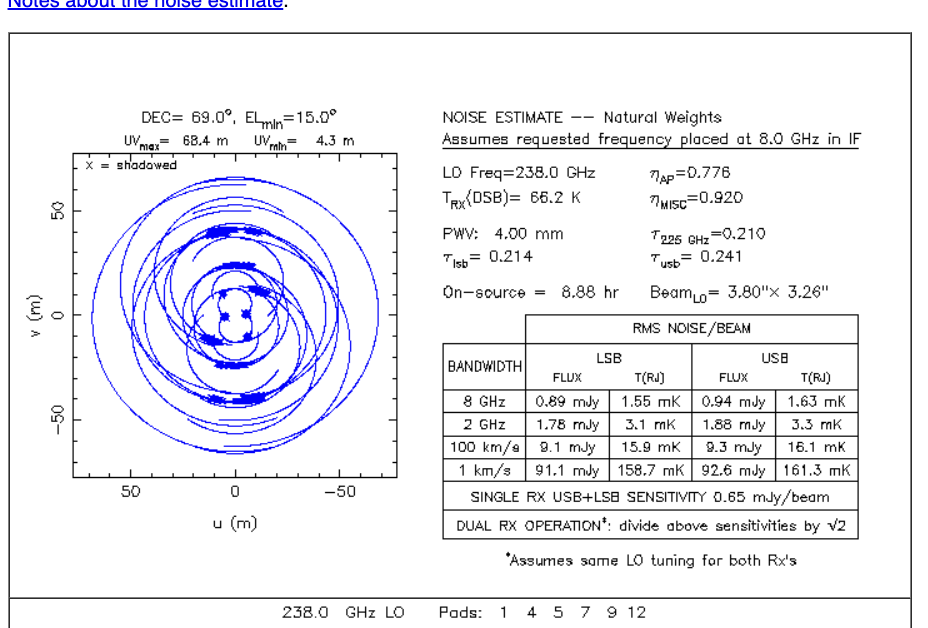

In [18]:
time_onsource_calc = 8.88 * u.hr

rms_calc = 91.1 * u.mJy / np.sqrt(2) / np.sqrt(linewidth.value)

print(target_rms_peak.to(u.mJy))

time_on_source_needed = time_onsource_calc.to(u.min) * (rms_calc / target_rms_peak.to(u.mJy))**2

time_on_source_needed


151.96774940370236 mJy


<Quantity 19.14688402 min>

## Equivalent continuum sensitivity

In [19]:
bandwidth_factor = (24 / 16.)

# Now this assumes uniform sensitivity over chunks 5/6 so is on the optimistic side.
# Though it's not the primary target/output here
rms_cont = 0.65 * u.mJy / np.sqrt(2) / np.sqrt(bandwidth_factor)

rms_cont_on_source = rms_cont * np.sqrt((time_onsource_calc.to(u.min) / time_on_source_needed)).to(u.one)

rms_cont_on_source

<Quantity 1.97963801 mJy>

# Mapping speed and total time estimates

Now incorporate the mapping speed:

Following the OTF time guide from the VLA here: https://science.nrao.edu/facilities/vla/docs/manuals/obsguide/modes/mosaicking

In [20]:
def otf_mapping_params(row_length, row_width,
                       theta_pb=55*u.arcsec,
                       time_per_beam=1*u.min,
                       t_dump=1.3 * u.s,
                       beam_per_dump=0.1,
                       t_loop = 15 * u.min,
                       t_gain = 3 * u.min,
                       time_per_track=time_onsource_calc,
                       t_delay=3*u.s,
                       t_row_delay=4*u.s,
                       verbose=True,
                      ):

    # R_target=3*u.arcsec/u.s,
    R_target = theta_pb * beam_per_dump / t_dump
    print(R_target)

    total_area = row_length * row_width
    
    beam_area = 0.5665 * theta_pb.to(u.arcmin).value**2 * u.arcmin**2
    
    N_eff = (total_area / beam_area).to(u.one)

    time_all_beams = (N_eff * time_per_beam)

    theta_row = theta_pb / np.sqrt(2)

    N_beam_row = (row_length / theta_pb).to(u.one)

    # Add 1 to account for start/end integration per row (if we need it)
    t_row = (row_length / R_target).to(u.min)
    
    Nrow = np.ceil((row_width / theta_row).to(u.one))
    
    # t_otf_map = Nrow * t_row

    t_otf_map = t_delay + Nrow * (t_row + t_row_delay)
    
    N_otf_maps = (time_all_beams / t_otf_map).to(u.one)

    # Add mapping overheads
    # Overhead. Assume we need 1 gain cal scan per 15 min.
    N_gain = np.ceil((t_otf_map / (t_loop - t_gain)).to(u.one)) - 1

    t_otf_map_total = (t_otf_map + N_gain * t_gain).to(u.h)

    t_total_mapping_time = N_otf_maps * t_otf_map_total

    N_tracks = t_total_mapping_time / time_per_track
    
    maps_per_track = np.ceil(N_otf_maps) / N_tracks

    out_dict = dict(row_length=row_length,
                   row_width=row_width,
                  total_area=row_length*row_width,
                   beam_area=beam_area,
                   N_eff=N_eff,
                   time_all_beams=time_all_beams.to(u.hr),
                   time_per_beam=time_per_beam,
                   theta_row=theta_row,
                   N_beam_row=N_beam_row,
                    R_target=R_target,
                   t_row=t_row,
                   Nrow=Nrow,
                   t_otf_map=t_otf_map.to(u.min),
                   N_otf_maps=N_otf_maps,
                   N_gain=N_gain,
                   t_otf_map_total=t_otf_map_total.to(u.hr),
                   t_total_mapping_time=t_total_mapping_time.to(u.hr),
                   N_tracks=N_tracks,
                   maps_per_track=maps_per_track)

    if verbose:
        for key in out_dict:
            print(key, out_dict[key])

    return out_dict


In [48]:


# M81
# row_length = 33.3 * u.arcmin
# row_width = 14 * u.arcmin

# row_length = 10. * u.arcmin
# row_width = 10. * u.arcmin

# row_length = 14. * u.arcmin
# row_width = 9.5 * u.arcmin

# Equiv. width to 3 piecewise boxes that minimizes empty space.
# row_length = 10.77 * u.arcmin
# row_width = 10.77 * u.arcmin

total_area = ((3.0 * 12) + (13.5 * 5) + (13 * 2.5)) * u.arcmin**2
print(total_area)
row_length = np.sqrt(total_area)
row_width = np.sqrt(total_area)

total_area = row_width * row_length

print(row_length, row_width)
# m81_otf = otf_mapping_params(row_length, row_width,
#                        theta_pb=55*u.arcsec,
#                        time_per_beam=time_on_source_needed,
#                        time_per_track=time_onsource_calc,
#                        R_target=3*u.arcsec/u.s,
#                        t_loop=15 * u.min,
#                        t_gain=1.5 * u.min,
#                       )

m81_otf = otf_mapping_params(row_length, row_width,
                       theta_pb=55*u.arcsec,
                       time_per_beam=time_on_source_needed,
                       time_per_track=time_onsource_calc,
                       t_dump=1.2*u.s,
                       t_loop=15 * u.min,
                       t_gain=1.5 * u.min,
                      )

# print(m81_otf)

############
## Additional target quick estimate map sizes.

# IC10
# row_length = 8 * u.arcmin
# row_width = 6 * u.arcmin

136.0 arcmin2
11.661903789690601 arcmin 11.661903789690601 arcmin
4.583333333333334 arcsec / s
row_length 11.661903789690601 arcmin
row_width 11.661903789690601 arcmin
total_area 136.0 arcmin2
beam_area 0.47601736111111104 arcmin2
N_eff 285.7038652593495
time_all_beams 91.17231287163048 h
time_per_beam 19.14688402038976 min
theta_row 38.89087296526011 arcsec
N_beam_row 12.722076861480657
R_target 4.583333333333334 arcsec / s
t_row 2.5444153722961307 min
Nrow 18.0
t_otf_map 47.04947670133036 min
N_otf_maps 116.2677920314287
N_gain 3.0
t_otf_map_total 0.8591579450221727 h
t_total_mapping_time 99.89239727398763 h
N_tracks 11.249143837160767
maps_per_track 10.40079153521876


In [52]:
# M82
row_length = 7.5 * u.arcmin
row_width = 6.0 * u.arcmin

m82_otf = otf_mapping_params(row_length, row_width,
                       theta_pb=55*u.arcsec,
                       time_per_beam=time_on_source_needed,
                       time_per_track=time_onsource_calc,
                       t_dump=1.2 * u.s,
                       beam_per_dump=0.07,
                       t_loop = 15 * u.min,
                       t_gain = 1.5 * u.min,
                      )

# Splitting into 2 interleaved halves. Match 1/2 total map time to 12 min
# so each full map is 30 min with 3 min per gains per 15 min loop.
print(m82_otf['t_otf_map']/2.)

3.208333333333334 arcsec / s
row_length 7.5 arcmin
row_width 6.0 arcmin
total_area 45.0 arcmin2
beam_area 0.47601736111111104 arcmin2
N_eff 94.53436718140242
time_all_beams 30.167309406054198 h
time_per_beam 19.14688402038976 min
theta_row 38.89087296526011 arcsec
N_beam_row 8.181818181818182
R_target 3.208333333333334 arcsec / s
t_row 2.337662337662337 min
Nrow 10.0
t_otf_map 24.09329004329004 min
N_otf_maps 75.12625137999142
N_gain 1.0
t_otf_map_total 0.426554834054834 h
t_total_mapping_time 32.04546569055398 h
N_tracks 3.6087236138011236
maps_per_track 21.060077781891433
12.04664502164502 min


In [43]:
# NGC3077
row_length = 8 * u.arcmin
row_width = 5.5 * u.arcmin

ngc3077_otf = otf_mapping_params(row_length, row_width,
                       theta_pb=55*u.arcsec,
                       time_per_beam=time_on_source_needed,
                       t_dump=1.2 * u.s,
                       t_loop = 15 * u.min,
                       t_gain = 1.5 * u.min,
                      )


4.583333333333334 arcsec / s
row_length 8.0 arcmin
row_width 5.5 arcmin
total_area 44.0 arcmin2
beam_area 0.47601736111111104 arcmin2
N_eff 92.43360346626014
time_all_beams 29.496924752586327 h
time_per_beam 19.14688402038976 min
theta_row 38.89087296526011 arcsec
N_beam_row 8.727272727272727
R_target 4.583333333333334 arcsec / s
t_row 1.7454545454545451 min
Nrow 9.0
t_otf_map 16.359090909090906 min
N_otf_maps 108.18544227122523
N_gain 1.0
t_otf_map_total 0.29765151515151506 h
t_total_mapping_time 32.20156080936695 h
N_tracks 3.6263018929467288
maps_per_track 30.05817033932239


In [44]:
# NGC2976
row_length = 4.2 * u.arcmin
row_width = 2.0 * u.arcmin

ngc2976_otf = otf_mapping_params(row_length, row_width,
                       theta_pb=55*u.arcsec,
                       time_per_beam=time_on_source_needed,
                       time_per_track=time_onsource_calc,
                       t_dump=1.2 * u.s,
                       t_loop = 15 * u.min,
                       t_gain = 1.5 * u.min,
                      )



4.583333333333334 arcsec / s
row_length 4.2 arcmin
row_width 2.0 arcmin
total_area 8.4 arcmin2
beam_area 0.47601736111111104 arcmin2
N_eff 17.64641520719512
time_all_beams 5.631231089130117 h
time_per_beam 19.14688402038976 min
theta_row 38.89087296526011 arcsec
N_beam_row 4.581818181818182
R_target 4.583333333333334 arcsec / s
t_row 0.9163636363636363 min
Nrow 4.0
t_otf_map 3.982121212121212 min
N_otf_maps 84.84770988872714
N_gain 0.0
t_otf_map_total 0.06636868686868687 h
t_total_mapping_time 5.631231089130118 h
N_tracks 0.6341476451723105
maps_per_track 134.03818597623874


In [45]:
# TidalTail_N
row_length = 2.0 * u.arcmin
row_width = 2.0 * u.arcmin

ttn_otf = otf_mapping_params(row_length, row_width,
                       theta_pb=55*u.arcsec,
                       time_per_beam=time_on_source_needed,
                       time_per_track=time_onsource_calc,
                       t_dump=1.2 * u.s,
                       t_loop = 15 * u.min,
                       t_gain = 1.5 * u.min,
                      )



4.583333333333334 arcsec / s
row_length 2.0 arcmin
row_width 2.0 arcmin
total_area 4.0 arcmin2
beam_area 0.47601736111111104 arcmin2
N_eff 8.403054860569105
time_all_beams 2.6815386138714845 h
time_per_beam 19.14688402038976 min
theta_row 38.89087296526011 arcsec
N_beam_row 2.1818181818181817
R_target 4.583333333333334 arcsec / s
t_row 0.4363636363636363 min
Nrow 4.0
t_otf_map 2.0621212121212116 min
N_otf_maps 78.02272528237386
N_gain 0.0
t_otf_map_total 0.03436868686868686 h
t_total_mapping_time 2.6815386138714845 h
N_tracks 0.30197506912967165
maps_per_track 261.61100062891774


In [46]:
all_otf_maps = {'m81': m81_otf,
                'm82': m82_otf,
                'ngc3077': ngc3077_otf,
                'ngc2976': ngc2976_otf,
                'ttn': ttn_otf}

In [47]:
# Summary of time and tracks needed:

all_time = sum([all_otf_maps[key]['t_otf_map'] * all_otf_maps[key]['N_otf_maps'] for key in all_otf_maps]).to(u.hr)

print(f"Proposal total time on source: {all_time}")


all_tracks = sum([all_otf_maps[key]['N_tracks'] for key in all_otf_maps])

print(f"Proposal total tracks: {all_tracks}")

total_area = sum([all_otf_maps[key]['total_area'] for key in all_otf_maps])

print(f"Proposal total area: {total_area}")

total_nbeams = sum([all_otf_maps[key]['N_eff'] for key in all_otf_maps])

print(f"Proposal total beams: {total_nbeams}")

Proposal total time on source: 159.14931673327257 h
Proposal total tracks: 19.433451823864996
Proposal total area: 237.4 arcmin2
Proposal total beams: 498.7213059747763


# M81: Expected CO(2-1) detections from scaling 8 um to CO intensity


Spitzer observations first described in [Willner+2004](https://ui.adsabs.harvard.edu/abs/2004ApJS..154..222W/abstract).

Existing BIMA 7-pt mosaic of M81's center from [Helfer+2003](https://ui.adsabs.harvard.edu/abs/2003ApJS..145..259H/abstract) (BIMA-SONG)

HI maps available from [Walter+2008](https://ui.adsabs.harvard.edu/abs/2008AJ....136.2563W/abstract) (THINGS; at ~6") and de Blok+2018 (at ~30").


In [28]:
spitzer8um = Projection.from_hdu(fits.open("~/storage/M81/NGC3031_irac4.fits"))

spitzer8um.unit

Unit("MJy / sr")

In [29]:
# Moderately smooth Spitzer to our target of 4"
spitzer8um._beam = Beam(2.8*u.arcsec)
spitzer8um = spitzer8um.convolve_to(Beam(4*u.arcsec))

In [30]:
# spitzer8um.quicklook()

In [31]:
# Leroy+23 7.7 um to CO from Figure

def ir_to_co(ir_img, m=1.1, b=-0.08):
    return 10**(np.log10(ir_img.to(u.MJy / u.sr).value)*m + b) * u.K * u.km / u.s


def co_to_ir(co_img, m=1.1, b=-0.08):
    # raise NotImplementedError("FIX THIS")
    return 10**((np.log10(co_img.to(u.K * u.km / u.s).value)- b) / m) * u.MJy / u.sr

In [32]:
co21_pred = ir_to_co(spitzer8um)

# Table 3 from Leroy+23a (larger scale, not with JWST bands)
# co21_pred = ir_to_co(spitzer8um, m=1.17, b=-0.19)

# co21_pred[co21_pred.value < 0.] = np.NaN
# co21_pred[co21_pred.value >= 1.e8] = np.NaN

/var/folders/zq/1v3_7dn10sl0f6m5xqw37fvw0000gn/T/ipykernel_46201/4125873062.py:4: RuntimeWarning: divide by zero encountered in log10
  return 10**(np.log10(ir_img.to(u.MJy / u.sr).value)*m + b) * u.K * u.km / u.s
/var/folders/zq/1v3_7dn10sl0f6m5xqw37fvw0000gn/T/ipykernel_46201/4125873062.py:4: RuntimeWarning: invalid value encountered in log10
  return 10**(np.log10(ir_img.to(u.MJy / u.sr).value)*m + b) * u.K * u.km / u.s


(900.0, 2300.0)

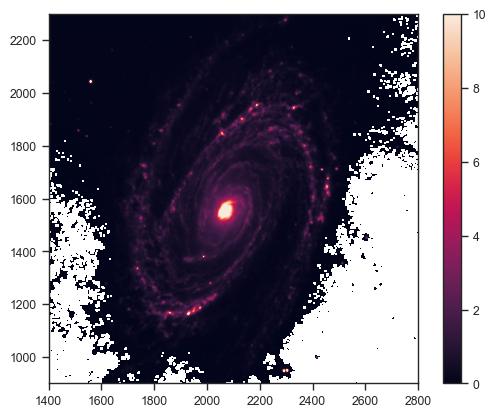

In [33]:
plt.imshow(co21_pred.value, origin='lower', vmax=10, vmin=0)
# plt.imshow(np.log10(co21_pred.value), origin='lower')#, vmax=100, vmin=0)

plt.colorbar()

plt.xlim([1400, 2800])
plt.ylim([900, 2300])

In [34]:
# targ_beam = Beam(3.5*u.arcsec)
targ_beam = Beam(5*u.arcsec)

target_rms_intint_K = target_rms_intint * (targ_beam.jtok(230.538*u.GHz) / u.Jy)

target_rms_intint_K

<Quantity 0.69889247 K km / s>

In [35]:
# Back to IR

target_rms_8um = co_to_ir(target_rms_intint_K)

# target_rms_8um = co_to_ir(target_rms_intint_K, m=1.17, b=-0.19)

target_rms_8um

<Quantity 0.85365452 MJy / sr>

In [36]:
print(3 * target_rms_8um)
print(5 * target_rms_8um)


2.5609635598295046 MJy / sr
4.268272599715841 MJy / sr


(900.0, 2300.0)

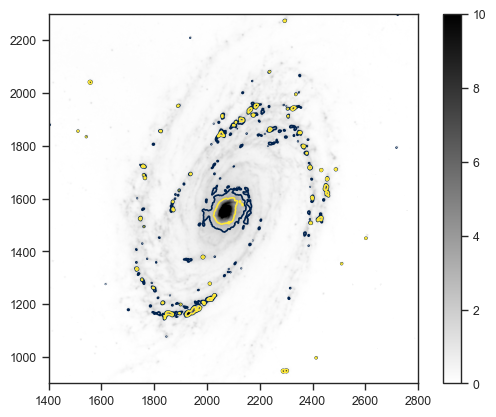

In [37]:
plt.imshow(co21_pred.value, origin='lower', vmax=10, vmin=0, cmap='binary')
plt.colorbar()

plt.contour(co21_pred.value, cmap='cividis', levels=[#arget_rms_intint_K.value,
                                                     3*target_rms_intint_K.value,
                                                     5*target_rms_intint_K.value])
# plt.contour(co21_pred > 5 * target_rms_intint_K, colors='g', levels=[0.5])

plt.xlim([1400, 2800])
plt.ylim([900, 2300])

Much of the center will not be detected, as shown by the BIMA-SONG data (though I still need to compare our sensitivity to theirs).


# Comparison between NOEMA CO(1-0) and SMA targeted CO(2-1) senstivity

In [38]:
noema_beam = Beam(2*u.arcsec)

noema_rms = 138 * u.mK # per 5 km/s.


noema_beam.jtok(115.38 * u.GHz)

<Quantity 22.95054024 K>

In [39]:
print(f"NOEMA 1-0: {noema_rms}")
print(f"SMA 2-1: {target_rms_peak_K.to(u.mK)}")


NOEMA 1-0: 138.0 mK
SMA 2-1: 218.4038955017157 mK


In [40]:
noema_rms_mjy = (noema_rms / (noema_beam.jtok(115.38 * u.GHz) / u.Jy)).to(u.mJy)

noema_rms_mjy

<Quantity 6.01293035 mJy>

In [41]:
print(f"NOEMA 1-0: {noema_rms_mjy}")
print(f"SMA 2-1: {target_rms_peak.to(u.mJy)}")

NOEMA 1-0: 6.012930352037646 mJy
SMA 2-1: 151.96774940370236 mJy
